In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

%matplotlib inline

microntoAA = 1.0e4
AAtomicron = 1.0e-4
AAtocm     = 1.0e-8
cmtoAA     = 1.0e8

#%load_ext fortranmagic  # activating magic

In [ ]:
# WD01 parameters:

# power              alpha_g, alpha_s
# curvature          beta_g, beta_s
# transition size    a_t_g, a_t_s
# upper cutoff       a_c_g, a_c_s
# total volume per H Vtot_g, Vtot_s

# Case A, they minimize chi^2 error.

# I'll use Case A, Rv=3.1, and bC = 6.e-5

In [32]:
def Da(asize, bc):
    """
    Equations 2 and 3 from Weingartner and Draine 2001, 548 : 296-309
    
    Return:
        D(a) in units 1 / Angstrom.
    
    ...
    """
    from scipy.special import erf

    rho = 2.24 * (AAtocm)**3  # g cm-3 Density of graphite
    mc  = 2.00844e-23         # g      Mass of a carbon atom = 12.*mH

    sigma = 0.4

    a0i = np.array([3.5, 30.])
    bci = np.array([0.75*bc, 0.25*bc]) # is the total C abundance (per H nucleus) in the log-normal populations.
    
    B0 = 3./(2.*np.pi)**(1.5)*np.exp(-4.5*sigma**2) / (rho * a0i[0]**3 * sigma) * bci[0]*mc \
        / (1. + erf(3.*sigma/np.sqrt(2.) + np.log(a0i[0]/3.5)/sigma*np.sqrt(2)))

    B1 = 3./(2.*np.pi)**(1.5)*np.exp(-4.5*sigma**2) / (rho * a0i[1]**3 * sigma) * bci[1]*mc \
        / (1. + erf(3.*sigma/np.sqrt(2.) + np.log(a0i[1]/3.5)/sigma*np.sqrt(2)))

    Da = B0 / asize * np.exp(-0.5*(np.log(asize/a0i[0])/sigma)**2) + B1 / asize * np.exp(-0.5*(np.log(asize/a0i[1])/sigma)**2)
    #Da = np.sum(Da)
    return Da

def FF(asize, beta, a_t):
    """
    Equation 6 from Weingartner and Draine 2001, 548 : 296-309
    ...
    """
    if beta >= 0:
        Fhere = 1.0 + beta*asize/a_t 
    else:
        Fhere = 1./(1.0 - beta*asize/a_t)
    return Fhere

def exp_cutoff(asize, a_t, a_c):
    """
    Exponential cutoff of the size distribution.
    Last term in equations 4 and 5 Weingartner and Draine 2001, 548.
    """
   
    if asize < a_t:
        ec = 1.0 
    else:
        ec = np.exp(-((asize-a_t)/a_c)**3)
    return ec  

def exp_cutoff_arr(asize, a_t, a_c):
    """
    Exponential cutoff of the size distribution.
    Last term in equations 4 and 5 Weingartner and Draine 2001, 548.
    """

    to_cut = (asize >= a_t)
    ones   = (asize <  a_t)
    
    ec = 1.0*ones + np.exp(-((asize-a_t)/a_c)**3)*to_cut
    
    return ec  

In [36]:
def get_size_dist(asize, grain_type):
    """
    Calculate the dust size distribution.
    
    Returns:
        1 / nH * dn / da in units of 1 / Angstrom
    
    """

    bc = 6.e-5     # Favoured distribution. See Figure 2 WD01. 

    if grain_type == "carbonaceous":
    
        # Carbonaceous grains:
        # Adjustable parameters: bc, Cg, a_t_g, a_c_g, alpha_g, beta_g
        Cg      = 9.99e-12
        a_t_g   = 0.0107*microntoAA # micron
        a_c_g   = 0.428*microntoAA # micron
        alpha_g = -1.54
        beta_g  = -0.165

        dnda = Da(asize, bc) + Cg/asize * (asize / a_t_g)**(alpha_g) * FF(asize, beta_g, a_t_g) * exp_cutoff_arr(asize, a_t_g, a_c_g)
    else:
        
        # silicate grains
        # Adjustable parameters: Cs, a_t_s, a_c_s, alpha_s, beta_s
        Cs      = 1.00e-13
        a_t_s   = 0.164*microntoAA
        a_c_s   = 0.1*microntoAA #microns ToDo: -> microntoAA
        alpha_s = -2.21
        beta_s  = 0.300

        dnda = Cs/asize * (asize / a_t_s)**(alpha_s) * FF(asize, beta_s, a_t_s) * exp_cutoff_arr(asize, a_t_s, a_c_s)
    
    return dnda

In [37]:
asize = 100. #grain size in Angstroms

dnda = get_size_dist(asize, "carbonaceous")

result = 4.*np.pi / 3. * asize**4 * dnda * (AAtocm)**3

In [38]:
print(result)

6.631077420117471e-29


In [59]:
# Size array in Angstroms.
asize = np.logspace(np.log10(3.5), np.log10(10000.), num=100)

dnda_c    = get_size_dist(asize, "carbonaceous")
size_dist_c = 4.*np.pi / 3. * asize**4 * dnda_c * (AAtocm)**3

dnda_s    = get_size_dist(asize, "silicates")
size_dist_s = 4.*np.pi / 3. * asize**4 * dnda_s * (AAtocm)**3

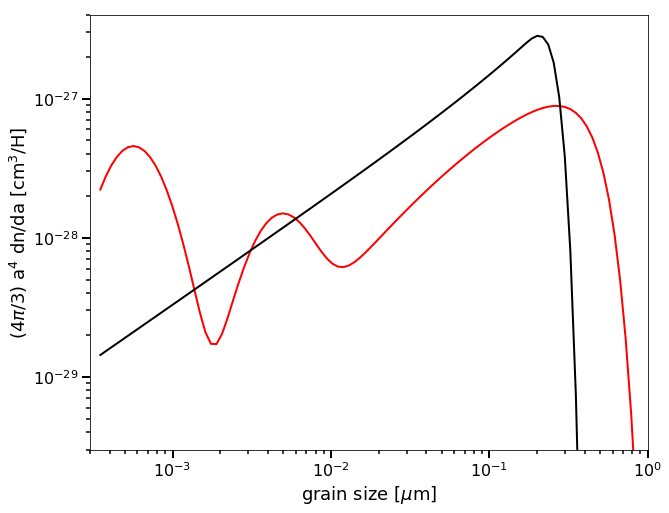

In [66]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(111)

ax.plot(asize*AAtomicron, size_dist_c, "-r", linewidth=2)
ax.plot(asize*AAtomicron, size_dist_s, "-k", linewidth=2)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(3.0e-4, 1.0)
ax.set_ylim(3.0e-30, 4.0e-27)


ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

ax.set_ylabel("$(4\pi/3)$ a$^4$ dn/da [cm$^{3}$/H]", fontsize=18)
ax.set_xlabel("grain size [$\mu$m]", fontsize=18)

ax.tick_params(axis='both', which='major', length=8, width=2, labelsize=16)
ax.tick_params(axis='both', which='minor', length=4, width=1.5, labelsize=12)


fig.show()